In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelBinarizer, StandardScaler, normalize
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers as layers
from tensorflow.keras import optimizers as optimizers
from tensorflow.keras import callbacks as callbacks

In [2]:
FORECAST_TOTAL_TIME = 7200
SAMPLE_TIME = 120
PEAK_TIME = 10

N_SAMPLES = FORECAST_TOTAL_TIME // SAMPLE_TIME
N_BINS_TOTAL = FORECAST_TOTAL_TIME // PEAK_TIME
N_BINS_SAMPLE = SAMPLE_TIME // PEAK_TIME

TAGS = ['SPORTS', 'NEWS', 'GAMING', 'FUNNY', 'DOCUMENTARY', 'COOKING', 'SCIENCE']

# Read data

In [3]:
all_data = pd.read_csv('../data/requests_data.csv')

In [4]:
all_data.head()

,endpoint,id,current_time,title,video_time,upload_time,youtuber_username,subscribers,tag,request_count
0,/send,1577833200,1577833200,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,1
1,/watch,1577833200,1577833200,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,94
2,/watch,1577833200,1577833201,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,88
3,/watch,1577833200,1577833202,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,98
4,/watch,1577833200,1577833203,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,89


In [5]:
data_send = all_data[all_data['endpoint'] == '/send'].drop(columns=["endpoint", "request_count", "upload_time", "title", "youtuber_username"])
data_send.set_index("id", inplace=True)
data_send

,current_time,video_time,subscribers,tag
id,,,,
1577833200,1577833200,463,2400,GAMING
1577833500,1577833500,596,2400,GAMING
1577833800,1577833800,94,1200,FUNNY
1577834100,1577834100,691,2400,NEWS
1577834400,1577834400,52,1200,COOKING
...,...,...,...,...
1577918100,1577918100,64,1200,FUNNY
1577918400,1577918400,296,800,NEWS
1577918700,1577918700,1,1200,FUNNY


In [6]:
data_watch = all_data[all_data['endpoint'] == '/watch'].drop(columns=["endpoint", "title", "youtuber_username", "video_time", "tag", "subscribers"])
data_watch

,id,current_time,upload_time,request_count
1,1577833200,1577833200,1577833200,94
2,1577833200,1577833201,1577833200,88
3,1577833200,1577833202,1577833200,98
4,1577833200,1577833203,1577833200,89
5,1577833200,1577833204,1577833200,93
...,...,...,...,...
476309,1577915400,1577919599,1577915400,193
476310,1577917800,1577919599,1577917800,123
476311,1577918700,1577919599,1577918700,0
476312,1577919000,1577919599,1577919000,0


In [7]:
# data_send.join(data_watch, on="movie_id", lsuffix="_L").head()

In [8]:
data_send["tag"].unique()

array(['GAMING', 'FUNNY', 'NEWS', 'COOKING', 'SPORTS', 'DOCUMENTARY',
       'SCIENCE'], dtype=object)

# Prepare dataset

In [9]:
binarizer = LabelBinarizer()
binarizer.fit(TAGS)
binarizer.classes_

array(['COOKING', 'DOCUMENTARY', 'FUNNY', 'GAMING', 'NEWS', 'SCIENCE',
       'SPORTS'], dtype='<U11')

In [10]:
tags_one_hot_encoded = binarizer.transform(data_send.tag)

In [11]:
n_requests_dict = {}

for movie_id in data_send.index:
    movie_requests_data = data_watch[np.logical_and(data_watch['id'] == movie_id, 
                                                    data_watch['current_time'] - data_watch['upload_time'] <= FORECAST_TOTAL_TIME)]
    
    upload_time = movie_requests_data['upload_time'].iloc[0]
    request_hist, bin_edges = np.histogram(
        a=movie_requests_data["current_time"],
        bins=N_BINS_TOTAL,
        range=(upload_time, upload_time + FORECAST_TOTAL_TIME),
        weights=movie_requests_data["request_count"]
    )
    
    request_max_count = []
    for start_bin in range(0, N_BINS_TOTAL, N_BINS_SAMPLE):
        request_max_count.append(max(request_hist[start_bin: start_bin + N_BINS_SAMPLE]))
    
    n_requests_dict[movie_id] = request_max_count

In [12]:
max(list(np.unique(np.array(list(n_requests_dict.values())[i]) > 0, return_counts=True)[1][1] * 2 for i in range(len(n_requests_dict)))) # 

118

In [13]:
feature_names = ['subscribers', 'video_time']

X = np.hstack([data_send[feature_names].astype(np.float16), tags_one_hot_encoded])
Y = np.array(list(n_requests_dict.values()))

X_scaler = StandardScaler()

X[:, :2] = X_scaler.fit_transform(X[:, :2])
Y, Y_norms = normalize(Y, return_norm=True)

X.shape, Y.shape

((288, 9), (288, 60))

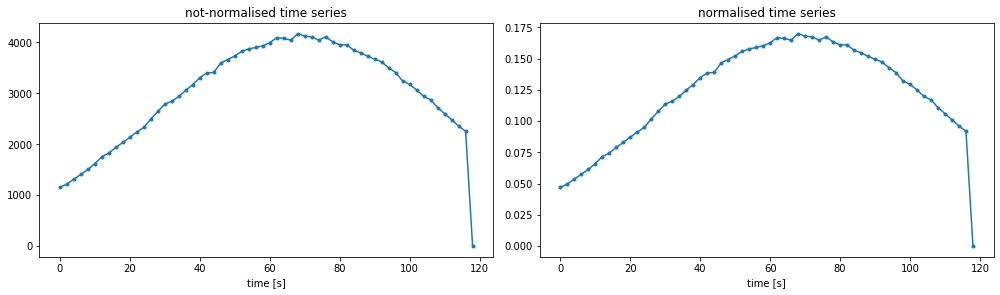

In [14]:
i = 252
# i = 19

plt.figure(figsize=(14, 4.2))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, FORECAST_TOTAL_TIME // 60, SAMPLE_TIME // 60), Y[i] * Y_norms[i], marker='.')
plt.title('not-normalised time series')
plt.xlabel('time [s]')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, FORECAST_TOTAL_TIME // 60, SAMPLE_TIME // 60), Y[i], marker='.')
plt.title('normalised time series')
plt.xlabel('time [s]')

plt.tight_layout()
plt.savefig('plots/time_series.pdf')

plt.show()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((230, 9), (58, 9), (230, 60), (58, 60))

# Utils

In [27]:
def plot_history(history, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    plt.plot(X, history['val_loss'], label='test')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"val_loss: {history[f'val_loss'][-1]:0.4f} (min: {min(history[f'val_loss']):0.4f})")
    plt.grid()
    plt.legend()
        
    plt.show()

# NN 0

In [118]:
model = tf.keras.Sequential([
    layers.Input(9),
    layers.Dense(60, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(96, activation="relu"),
    # layers.Dense(5, activation="relu"),
    # layers.Dense(20, activation="relu"),
    # layers.Dense(15, activation="relu"),
    # layers.Dense(9, activation="relu"),
    # *[layers.Dense(1, activation="relu") for _ in range(9)],    
    # layers.Dense(12, activation="relu"),
    layers.Dense(60),
])

model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_286 (Dense)           (None, 60)                600       
                                                                 
 dense_287 (Dense)           (None, 128)               7808      
                                                                 
 dense_288 (Dense)           (None, 96)                12384     
                                                                 
 dense_289 (Dense)           (None, 60)                5820      
                                                                 
Total params: 26,612
Trainable params: 26,612
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(optimizers.Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train, Y_train, batch_size=1024, epochs=600, validation_data=(X_test, Y_test)).history

Epoch 1/600
1/1 [==============================] - 0s 326ms/step - loss: 0.0261 - val_loss: 0.0221
Epoch 2/600
1/1 [==============================] - 0s 20ms/step - loss: 0.0222 - val_loss: 0.0191
Epoch 3/600
1/1 [==============================] - 0s 25ms/step - loss: 0.0194 - val_loss: 0.0170
Epoch 4/600
1/1 [==============================] - 0s 23ms/step - loss: 0.0172 - val_loss: 0.0153
Epoch 5/600
1/1 [==============================] - 0s 25ms/step - loss: 0.0156 - val_loss: 0.0140
Epoch 6/600
1/1 [==============================] - 0s 23ms/step - loss: 0.0143 - val_loss: 0.0129
Epoch 7/600
1/1 [==============================] - 0s 24ms/step - loss: 0.0132 - val_loss: 0.0121
Epoch 8/600
1/1 [==============================] - 0s 23ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 9/600
1/1 [==============================] - 0s 24ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 10/600
1/1 [==============================] - 0s 23ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 11/600
1/1 [

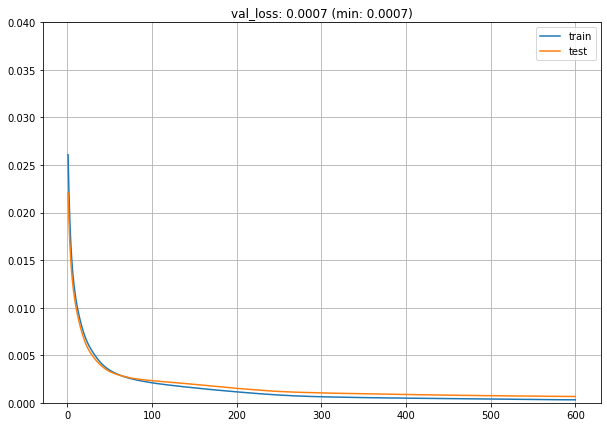

In [120]:
plot_history(history, ymax=0.04)

# NN 1

In [22]:
# features_input = layers.Input(9)
# time_series_input = layers.Input(N_SAMPLES)
# time_series_input = layers.Reshape((-1, 1))(time_series_input)

# x = layers.GRU(9, return_sequences=True)(time_series_input, initial_state=features_input)

# x = layers.TimeDistributed(layers.Dense(1))(x)
# outputs = layers.Flatten()(x)

# model = tf.keras.Model(inputs=[features_input, time_series_input], outputs=outputs)

# model.summary()

In [33]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.gru_cell = tf.keras.layers.GRUCell(units)
        self.dense = tf.keras.layers.Dense(1)
    
    def call(self, inputs, training=None):
        predictions = []
        
        if training:
            time_series, features = inputs
            time_series = layers.Reshape((-1, 1))(time_series)
        else:
            features = inputs
        
        state = features
        x = tf.zeros((tf.shape(features)[0], 1))

        # Run the rest of the prediction steps.
        for step_i in range(self.out_steps):
            # Execute one lstm step.
            x, state = self.gru_cell(x, states=state,
                                     training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)
            
            # Use the last prediction as input.
            if training:
                x = time_series[:, step_i]
            else:
                # Use the last prediction as input.
                x = prediction
                

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [34]:
model = FeedBack(9, N_SAMPLES)

model.compile(optimizers.Adam(learning_rate=0.002), loss='mse')
history = model.fit((Y_train, X_train), Y_train, batch_size=1024, epochs=500, validation_data=(X_test, Y_test)).history

Epoch 1/500
1/1 [==============================] - 13s 13s/step - loss: 0.0204 - val_loss: 0.0161
Epoch 2/500
1/1 [==============================] - 0s 107ms/step - loss: 0.0186 - val_loss: 0.0157
Epoch 3/500
1/1 [==============================] - 0s 113ms/step - loss: 0.0174 - val_loss: 0.0160
Epoch 4/500
1/1 [==============================] - 0s 108ms/step - loss: 0.0169 - val_loss: 0.0166
Epoch 5/500
1/1 [==============================] - 0s 112ms/step - loss: 0.0167 - val_loss: 0.0171
Epoch 6/500
1/1 [==============================] - 0s 117ms/step - loss: 0.0165 - val_loss: 0.0174
Epoch 7/500
1/1 [==============================] - 0s 111ms/step - loss: 0.0162 - val_loss: 0.0173
Epoch 8/500
1/1 [==============================] - 0s 110ms/step - loss: 0.0157 - val_loss: 0.0170
Epoch 9/500
1/1 [==============================] - 0s 119ms/step - loss: 0.0152 - val_loss: 0.0166
Epoch 10/500
1/1 [==============================] - 0s 115ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 11/5

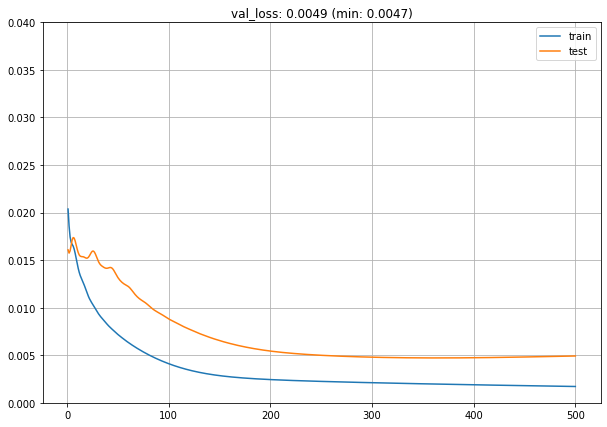

In [35]:
plot_history(history, ymax=0.04)

---

In [74]:
class FeedBack2(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.dense = tf.keras.layers.Dense(1)
    
    def call(self, inputs, training=None):
        predictions = []
        
        if training:
            time_series, features = inputs
            time_series = layers.Reshape((-1, 1))(time_series)
        else:
            features = inputs
        
        state = [
            tf.concat([features, features], axis=1),
            tf.concat([features, features], axis=1)
        ]
        x = tf.zeros((tf.shape(features)[0], 1))

        # Run the rest of the prediction steps.
        for step_i in range(self.out_steps):
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                     training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)
            
            # Use the last prediction as input.
            if training:
                x = time_series[:, step_i]
            else:
                # Use the last prediction as input.
                x = prediction
                

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [75]:
model = FeedBack2(18, N_SAMPLES)

model.compile(optimizers.Adam(learning_rate=0.002), loss='mse')
history = model.fit((Y_train, X_train), Y_train, batch_size=1024, epochs=500, validation_data=(X_test, Y_test)).history

Epoch 1/500
1/1 [==============================] - 9s 9s/step - loss: 0.0207 - val_loss: 0.0236
Epoch 2/500
1/1 [==============================] - 0s 108ms/step - loss: 0.0194 - val_loss: 0.0226
Epoch 3/500
1/1 [==============================] - 0s 117ms/step - loss: 0.0184 - val_loss: 0.0219
Epoch 4/500
1/1 [==============================] - 0s 102ms/step - loss: 0.0176 - val_loss: 0.0214
Epoch 5/500
1/1 [==============================] - 0s 97ms/step - loss: 0.0169 - val_loss: 0.0211
Epoch 6/500
1/1 [==============================] - 0s 99ms/step - loss: 0.0164 - val_loss: 0.0208
Epoch 7/500
1/1 [==============================] - 0s 97ms/step - loss: 0.0159 - val_loss: 0.0205
Epoch 8/500
1/1 [==============================] - 0s 118ms/step - loss: 0.0155 - val_loss: 0.0201
Epoch 9/500
1/1 [==============================] - 0s 111ms/step - loss: 0.0150 - val_loss: 0.0196
Epoch 10/500
1/1 [==============================] - 0s 91ms/step - loss: 0.0145 - val_loss: 0.0190
Epoch 11/500
1/1

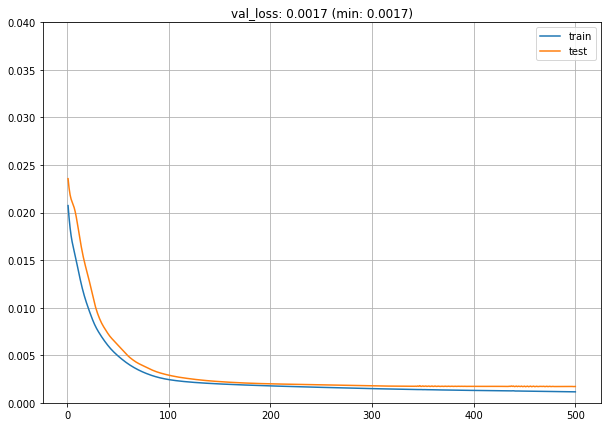

In [76]:
plot_history(history, ymax=0.04)

In [77]:
model.summary()

Model: "feed_back2_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_6 (LSTMCell)      multiple                  1440      
                                                                 
 dense_33 (Dense)            multiple                  19        
                                                                 
Total params: 1,459
Trainable params: 1,459
Non-trainable params: 0
_________________________________________________________________
